In [1]:
import os
import sys
from typing import Union

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from ydata_profiling import ProfileReport

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.environment import REPORTS_DIR, METRICS_DIR, ROOT
from src.features.preprocessing import MJOULES_TO_JOULES, HOURS_TO_MILISECONDS

CLEAN_RUN = False
SAVE_FIGS = True
FIGURES_FORMAT = "pdf"

sns.set_theme(palette="colorblind", color_codes=True)

%matplotlib inline

mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "Times New Roman"
mpl.rcParams["font.weight"] = "bold"
mpl.rcParams["font.size"] = 12
mpl.rcParams["figure.autolayout"] = "true"
mpl.rcParams["axes.grid"] = "true"
mpl.rcParams["grid.color"] = "gray"

## Load data


In [2]:
INDEPENDENT_VARIABLES = [
    "training environment",
    "architecture",
    "dataset",
    "batch size",
    "image size",
    "total ram (GB)",
]
RELEVANT_METRICS = [
    "run_id",
    "start time",
    "training duration (h)",
    "return code",
    "gpu usage (%)",
    "average gpu power (W)",
    "gpu energy (MJ)",
    "max power limit (W)",
    "ram energy (MJ)",
    "energy (MJ)",
    "average temperature (Celsius)",
    "GFLOPs",
    "trained epochs",
    "measured epochs",
    "total seen images",
]

In [3]:
aggregated_metrics = pd.read_parquet(
    METRICS_DIR / "processed" / "dl-training-energy-consumption-dataset.gzip"
).sort_values(by=["start time"])

In [4]:
# Remove runs that did not finish successfully
original_number_of_runs = len(aggregated_metrics)
aggregated_metrics = aggregated_metrics.loc[aggregated_metrics["return code"] == 0]
print(f"Inital number of runs: {original_number_of_runs}")
print(f"Removed {original_number_of_runs - len(aggregated_metrics)} runs")
print(f"Number of runs: {len(aggregated_metrics)}")

Inital number of runs: 1630
Removed 107 runs
Number of runs: 1523


## Automatic EDA with Ydata Profiling


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/home/santiago/.cache/pypoetry/virtualenvs/seaa2023-ect-extension-5MNfinQm-py3.10/lib/python3.10/site-packages/ydata_profiling/model/correlations.py:66: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: 'mobilenet_v2'')
  warnings.warn(
/home/santiago/.cache/pypoetry/virtualenvs/seaa2023-ect-extension-5MNfinQm-py3.10/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)
/home/santiago/.cache/pypoetry/virtualenvs/seaa2023-ect-extension-5MNfinQm-py3.10/lib/python3.10/site-packages/yda

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

/home/santiago/.cache/pypoetry/virtualenvs/seaa2023-ect-extension-5MNfinQm-py3.10/lib/python3.10/site-packages/ydata_profiling/visualisation/utils.py:73: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(


Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

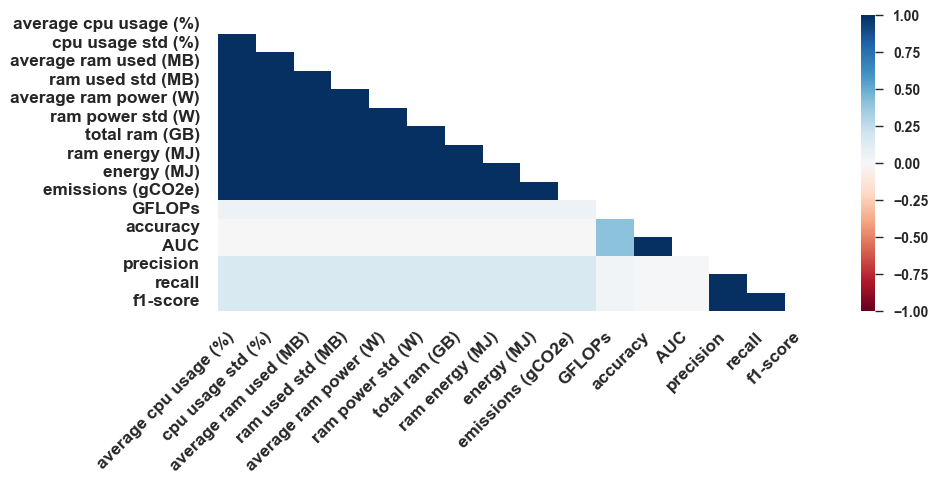

In [5]:
if not os.path.exists(REPORTS_DIR / "dl-training-energy-consumption-dataset.html") or CLEAN_RUN:
    type_schema = {
        "training environment": "categorical",
        "architecture": "categorical",
        "dataset": "categorical",
        "run": "numeric",
        "run_id": "categorical",
        "start time": "datetime",
        "training duration (h)": "numeric",
        "gpu model": "categorical",
        "gpu working time (h)": "numeric",
        "gpu usage (%)": "numeric",
        "gpu memory working time (h)": "numeric",
        "gpu memory usage": "numeric",
        "gpu average memory used (MB)": "numeric",
        "gpu memory used std (MB)": "numeric",
        "total power (W)": "numeric",
        "average gpu power (W)": "numeric",
        "gpu power std (W)": "numeric",
        "max power limit (W)": "numeric",
        "average temperature (Celsius)": "numeric",
        "temperature std (Celsius)": "numeric",
        "average cpu usage (%)": "numeric",
        "cpu usage std (%)": "numeric",
        "average ram used (MB)": "numeric",
        "ram used std (MB)": "numeric",
        "average ram power (W)": "numeric",
        "ram power std (W)": "numeric",
        "total ram (GB)": "numeric",
        "gpu energy (MJ)": "numeric",
        "ram energy (MJ)": "numeric",
        "energy (MJ)": "numeric",
        "emissions (gCO2e)": "numeric",
        "mlflow run id": "categorical",
        "training size": "numeric",
        "validation size": "numeric",
        "batch size": "numeric",
        "image size": "categorical",
        "trained epochs": "numeric",
        "GFLOPs": "numeric",
        "accuracy": "numeric",
        "AUC": "numeric",
        "split number": "numeric",
        "total seen images": "numeric",
        "precision": "numeric",
        "recall": "numeric",
        "f1-score": "numeric",
        "return code": "numeric",
    }
    profile = ProfileReport(
        aggregated_metrics,
        title="Deep Learning Training Energy Consumption Dataset",
        type_schema=type_schema,
        explorative=True,
    )
    profile.to_file(ROOT / "reports" / "dl-training-energy-consumption-dataset.html")

## Data Cleaning


In [6]:
TRAIN_STRATEGIES = aggregated_metrics["training environment"].unique()
MARKERS = {
    "MobileNet V2": "o",
    "NASNet Mobile": "v",
    "Xception": "^",
    "ResNet50": "X",
    "VGG16": "P",
}
COLORS = {environment: color for environment, color in zip(TRAIN_STRATEGIES, ["b", "orange", "g"])}
ARCHITECTURE_LABELS = ["MobileNet\nV2", "NASNet\nMobile", "ResNet50", "VGG16", "Xception"]

In [7]:
analysis_df = aggregated_metrics[INDEPENDENT_VARIABLES + RELEVANT_METRICS].copy()

Look for missing values


In [8]:
analysis_df.isna().any(axis=0)

training environment             False
architecture                     False
dataset                          False
batch size                       False
image size                       False
total ram (GB)                    True
run_id                           False
start time                       False
training duration (h)            False
return code                      False
gpu usage (%)                    False
average gpu power (W)            False
gpu energy (MJ)                  False
max power limit (W)              False
ram energy (MJ)                   True
energy (MJ)                       True
average temperature (Celsius)    False
GFLOPs                            True
trained epochs                   False
measured epochs                  False
total seen images                False
dtype: bool

The only columns with missing values are the ones related to the RAM and the GFLOPs.

Since all runs have the same total RAM and GFLOPs for a given setting we just propagate the values to those with NaN.


In [9]:
analysis_df.loc[:, "total ram (GB)"] = (
    analysis_df.groupby(INDEPENDENT_VARIABLES[:-1], as_index=False)["total ram (GB)"].bfill().ffill()
)

In [10]:
analysis_df.loc[:, "GFLOPs"] = analysis_df.groupby(INDEPENDENT_VARIABLES, as_index=False)["GFLOPs"].bfill().ffill()

In [11]:
analysis_df.groupby(INDEPENDENT_VARIABLES, dropna=False).agg({"run_id": "count", "ram energy (MJ)": "count"})

run_id  \
training environment architecture  dataset             batch size image size total ram (GB)           
Cloud                inception_v3  caltech101          32         (128, 128) 16.0                30   
                                                                  (224, 224) 16.0                30   
                                                                  (75, 75)   16.0                30   
                                                       64         (128, 128) 16.0                30   
                                                                  (224, 224) 16.0                30   
                                                                  (75, 75)   16.0                30   
                                                       256        (128, 128) 16.0                30   
                                                                  (224, 224) 16.0                30   
                                                                  (75, 75)   16.0                60   
                                   stanford_dogs       32         (128, 128) 16.0                30   
                                                                  (224, 224) 16.0                 5   
                                                                  (75, 75)   16.0                30   
                                                       64         (128, 128) 16.0                30   
                                                                  (75, 75)   16.0                30   
                                                       256        (128, 128) 8.0                 30   
                                                                             16.0                30   
                                                                             24.0                30   
                                                                             32.0                30   
                                                                  (75, 75)   16.0                30   
                     mobilenet_v2  chesslive-occupancy 32         (128, 128) 16.0                30   
                     nasnet_mobile chesslive-occupancy 32         (128, 128) 16.0                28   
                     resnet50      chesslive-occupancy 32         (128, 128) 16.0                30   
                     vgg16         chesslive-occupancy 32         (128, 128) 16.0                30   
                     xception      chesslive-occupancy 32         (128, 128) 16.0                30   
Local ML Engineer    inception_v3  caltech101          32         (128, 128) 32.0                32   
                                                                  (224, 224) 32.0                32   
                                                                  (75, 75)   32.0                31   
                                                       64         (128, 128) 32.0                32   
                                                                  (224, 224) 32.0                30   
                                                                  (75, 75)   32.0                31   
                                                       256        (128, 128) 32.0                30   
                                                                  (224, 224) 32.0                30   
                                                                  (75, 75)   32.0                59   
                                   stanford_dogs       32         (128, 128) 32.0                31   
                                                                  (224, 224) 32.0                30   
                                                                  (75, 75)   32.0                30   
                                                       64         (128, 128) 32.0                30   
                                                                  (224, 224)

Since we have no information about the energy consumption of the RAM and the number of runs under this circumstance is not too big, we will remove them from the data.


In [12]:
analysis_df.dropna(inplace=True)
print(f"Number of runs after eliminating NaNs: {len(analysis_df)}")

Number of runs after eliminating NaNs: 1410


Next, we proceed to eliminate those runs that have measurements for less than 20 epochs.
This is to ensure we have enough data of the training process to make a good estimation of the energy consumption.

In [13]:
metrics_df = pd.read_parquet(os.path.join(METRICS_DIR, "interim", "dl-training-profiling-dataset.gzip"))
metrics_df = metrics_df.loc[metrics_df["run_id"].isin(analysis_df["run_id"])]
run_max_epochs = metrics_df.groupby("run_id", as_index=False)["epoch"].max()
run_max_epochs.rename(columns={"epoch": "measured epochs"}, inplace=True)
run_max_epochs["measured epochs"] = run_max_epochs["measured epochs"] + 1

valid_runs = run_max_epochs.query("`measured epochs` >= 20")["run_id"].unique()

print(f"Invalid runs: {len(run_max_epochs) - len(valid_runs)}")

Invalid runs: 5


In [14]:
analysis_df.query("`run_id` in @valid_runs", inplace=True)
print(f"Number of runs after eliminating invalid runs: {len(analysis_df)}")

Number of runs after eliminating invalid runs: 1405


Next, we remove those runs where the epoch duration is below the sampling rate since we will not be able to make a good estimation of the energy consumption.

In [15]:
epoch_energy_df = pd.read_parquet(METRICS_DIR / "interim" / "dl-epoch-energy-consumption-dataset.gzip")
epoch_energy_df["epoch"] = epoch_energy_df["epoch"].astype("int")

In [16]:
tmp = metrics_df.sort_values(["run_id", "timestamp"])
tmp["sampling_period"] = tmp.groupby("run_id", as_index=False)["timestamp"].diff().dt.total_seconds()

In [17]:
tmp = tmp.groupby(["train_environment", "architecture", "dataset", "run_id"], as_index=False)["sampling_period"].min()

epoch_time = epoch_energy_df.groupby("run_id", as_index=False)["duration (s)"].min()

tmp = tmp.merge(epoch_time, on="run_id", how="left")
problematic_runs = tmp.query("`sampling_period` > `duration (s)`")

problematic_runs.groupby("train_environment", as_index=False).agg({"run_id": "count"})

,train_environment,run_id
0,cloud,20
1,local,20


In [18]:
analysys_df = analysis_df.query("`run_id` not in @problematic_runs['run_id']", inplace=True)
print(f"Number of runs after eliminating problematic runs: {len(analysis_df)}")

Number of runs after eliminating problematic runs: 1365


Now we proceed to remove the outliers. Manually inspecting all the data would take too much time. Hence, we will use an
Isolation Forest model to detect possible outliers. Finally, we will check if the number of outliers is reasonable based
on our previous knowledge. This is to make sure that we still have enough data for the final analysis.


In [19]:
analysis_df["normalized energy"] = analysis_df["energy (MJ)"] * MJOULES_TO_JOULES / analysis_df["total seen images"]
analysis_df["normalized duration"] = (
    analysis_df["training duration (h)"] * HOURS_TO_MILISECONDS / analysis_df["total seen images"]
)

In [20]:
X = analysis_df.drop(columns=["run_id", "start time", "return code", "training duration (h)", "energy (MJ)"])
X_numerical = X.select_dtypes(include=["int64", "float64"])
X_categorical = X.select_dtypes(include=["object"])
X_standardized = StandardScaler().fit_transform(X_numerical)
X_numerical = pd.DataFrame(X_standardized, index=X_numerical.index, columns=X_numerical.columns)
X = pd.concat([X_numerical, X_categorical], axis=1)
X_encoded = pd.get_dummies(X)

In [21]:
X_encoded.head()

,batch size,total ram (GB),gpu usage (%),average gpu power (W),gpu energy (MJ),max power limit (W),ram energy (MJ),average temperature (Celsius),GFLOPs,trained epochs,...,architecture_nasnet_mobile,architecture_resnet50,architecture_vgg16,architecture_xception,dataset_caltech101,dataset_chesslive-occupancy,dataset_stanford_dogs,"image size_(128, 128)","image size_(224, 224)","image size_(75, 75)"
0,-0.732871,-1.16386,-2.152487,-0.639825,0.439331,0.980106,0.049046,-1.228523,-0.88995,-0.899751,...,False,False,False,False,False,True,False,True,False,False
1,-0.732871,-1.16386,-2.154564,-0.693284,0.522208,0.980106,0.104790,-1.313951,-0.88995,-0.753210,...,False,False,False,False,False,True,False,True,False,False
2,-0.732871,-1.16386,-2.185944,-0.739018,-0.103941,0.980106,-0.125368,-1.391482,-0.88995,-2.108715,...,False,False,False,False,False,True,False,True,False,False
3,-0.732871,-1.16386,-2.163967,-0.646093,0.242754,0.980106,-0.008150,-1.271006,-0.88995,-1.412645,...,False,False,False,False,False,True,False,True,False,False
4,-0.732871,-1.16386,-2.168640,-0.748704,0.241411,0.980106,0.013608,-1.371477,-0.88995,-1.339375,...,False,False,False,False,False,True,False,True,False,False


In [22]:
def detect_outliers(
    data: pd.DataFrame, n_estimators: int = 100, warm_start: bool = True, contamination: Union[str, float] = "auto"
):
    clf = IsolationForest(n_estimators=n_estimators, warm_start=warm_start, contamination=contamination)
    return clf.fit_predict(data.select_dtypes(include="number"))

In [23]:
groups = []
n_estimators = 100
warm_start = True
contamination = 0.1
for index, group in X.groupby(["training environment", "architecture", "dataset"], as_index=False):
    group["is outlier"] = detect_outliers(pd.get_dummies(group), n_estimators, warm_start, contamination) == -1
    groups.append(group)

outliers_df = pd.concat(groups)
outliers_df

,batch size,total ram (GB),gpu usage (%),average gpu power (W),gpu energy (MJ),max power limit (W),ram energy (MJ),average temperature (Celsius),GFLOPs,trained epochs,measured epochs,total seen images,normalized energy,normalized duration,training environment,architecture,dataset,image size,is outlier
1027,-0.732871,-1.163860,-0.064779,1.651495,0.478514,0.980106,-0.154280,0.453217,1.348796,2.507328,2.588120,-0.441441,1.076345,-0.047410,Cloud,inception_v3,caltech101,"(224, 224)",True
1028,1.557052,-1.163860,0.715016,1.562930,-0.389483,0.980106,-0.332452,0.359695,1.348796,0.272577,0.375255,-1.241231,0.246191,-0.211922,Cloud,inception_v3,caltech101,"(224, 224)",False
1029,-0.732871,-1.163860,-0.104294,1.615164,0.001701,0.980106,-0.262422,0.407854,1.348796,0.272577,0.375255,-1.175374,1.104775,-0.037644,Cloud,inception_v3,caltech101,"(224, 224)",False
1032,-0.405739,-1.163860,0.309424,1.504423,-0.034009,0.980106,-0.256572,0.311859,1.348796,1.444906,1.536102,-0.796777,0.559753,-0.141513,Cloud,inception_v3,caltech101,"(224, 224)",False
1035,-0.732871,-1.163860,-0.134334,1.606793,0.066942,0.980106,-0.247985,0.424211,1.348796,0.565659,0.665467,-1.079120,1.105462,-0.036678,Cloud,inception_v3,caltech101,"(224, 224)",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,-0.732871,0.821976,1.386420,-2.564539,1.761744,-3.082458,6.481230,-1.110833,-0.771911,-1.632457,-1.511121,0.426655,2.448368,6.387671,Local Normal User,nasnet_mobile,chesslive-occupancy,"(128, 128)",False
146,-0.732871,0.821976,1.382864,-2.566284,1.883780,-3.082458,6.628958,-1.162875,-0.771911,-1.522551,-1.402291,0.561030,2.435950,6.419593,Local Normal User,nasnet_mobile,chesslive-occupancy,"(128, 128)",False
147,-0.732871,0.821976,1.386177,-2.565846,2.510462,-3.082458,8.207418,-1.157327,-0.771911,-1.009657,-0.894421,1.188112,2.504990,6.540554,Local Normal User,nasnet_mobile,chesslive-occupancy,"(128, 128)",False
148,-0.732871,0.821976,1.385983,-2.565531,1.842923,-3.082458,6.483448,-1.155029,-0.771911,-1.559186,-1.438568,0.516238,2.431248,6.405710,Local Normal User,nasnet_mobile,chesslive-occupancy,"(128, 128)",False


In [24]:
analysis_df["is outlier"] = outliers_df["is outlier"]

In [25]:
print(f"Number of outliers: {outliers_df.loc[outliers_df['is outlier']].shape[0]}")

Number of outliers: 140


In [26]:
print("Number of outliers by training environment and architecture:")
analysis_df.groupby(INDEPENDENT_VARIABLES[:3])["is outlier"].value_counts()

Number of outliers by training environment and architecture:


training environment  architecture   dataset              is outlier
Cloud                 inception_v3   caltech101           False         196
                                                          True           22
                                     stanford_dogs        False         210
                                                          True           24
                      mobilenet_v2   chesslive-occupancy  False          27
                                                          True            3
                      nasnet_mobile  chesslive-occupancy  False          20
                                                          True            3
                      resnet50       chesslive-occupancy  False          27
                                                          True            3
                      vgg16          chesslive-occupancy  False          27
                                                          True            3
                   

<Axes: xlabel='average gpu power (W)', ylabel='gpu usage (%)'>

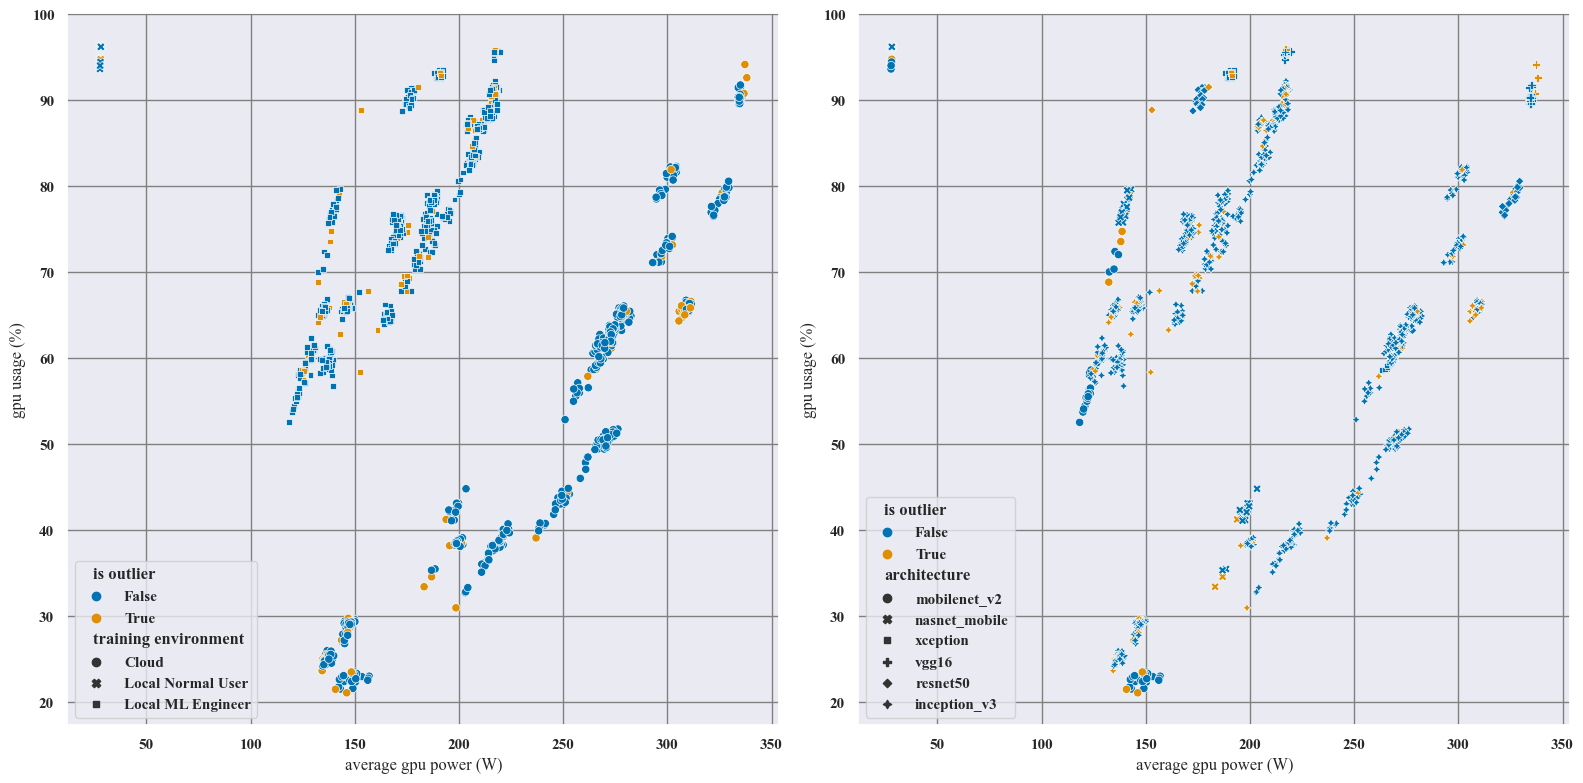

In [27]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 8))
sns.scatterplot(
    x="average gpu power (W)",
    y="gpu usage (%)",
    hue="is outlier",
    style="training environment",
    data=analysis_df,
    ax=ax0,
)
sns.scatterplot(
    x="average gpu power (W)",
    y="gpu usage (%)",
    hue="is outlier",
    style="architecture",
    data=analysis_df,
    ax=ax1,
)

In [28]:
cleaned_data = aggregated_metrics.loc[
    aggregated_metrics["run_id"].isin(analysis_df["run_id"].loc[~analysis_df["is outlier"]])
]
print(f"Number of runs after eliminating outliers: {len(cleaned_data)}")

Number of runs after eliminating outliers: 1225


In [29]:
cleaned_data.to_parquet(
    METRICS_DIR / "processed" / "clean-dl-training-energy-consumption-dataset.gzip", compression="gzip"
)

In [30]:
clean_epoch_energy = epoch_energy_df.loc[epoch_energy_df["run_id"].isin(cleaned_data["run_id"])]
clean_epoch_energy.to_parquet(
    METRICS_DIR / "processed" / "clean-dl-epoch-energy-consumption-dataset.gzip", compression="gzip"
)